# **SE4050 - Deep Learning Assignment**

IT21479632 - Wijekoon W.M.K.G.S.S.B

MODEL - Multilayer Perceptron (MLP)

In [293]:
# Import necessary libraries

!pip install pandas scikit-learn matplotlib seaborn tensorflow

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


In [47]:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Data Preprocessing**

In [271]:
# Load the dataset

data = pd.read_csv('/content/drive/MyDrive/DL Assignment/insurance_claims.csv')

In [272]:
# Drop irrelevant columns

irrelevant_cols = ['policy_number', 'policy_bind_date', 'incident_date', 'incident_location', 'insured_zip', '_c39']
data = data.drop(columns=irrelevant_cols)

In [273]:
# Handle missing values (replace '?' with NaN for imputation)

data.replace('?', pd.NA, inplace=True)

In [274]:
# Display the first few rows of the loaded dataset

print("Loaded dataset:")
display(data.head())

Loaded dataset:


,months_as_customer,age,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_sex,insured_education_level,insured_occupation,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,OH,250/500,1000,1406.91,0,MALE,MD,craft-repair,...,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,IN,250/500,2000,1197.22,5000000,MALE,MD,machine-op-inspct,...,0,<NA>,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,OH,100/300,2000,1413.14,5000000,FEMALE,PhD,sales,...,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,IL,250/500,2000,1415.74,6000000,FEMALE,PhD,armed-forces,...,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,IL,500/1000,1000,1583.91,6000000,MALE,Associate,sales,...,1,NO,6500,1300,650,4550,Accura,RSX,2009,N


In [275]:
# Identify numerical and categorical columns

numerical_cols = ['months_as_customer', 'age', 'policy_deductable', 'policy_annual_premium', 'umbrella_limit',
                  'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim', 'incident_hour_of_the_day']

categorical_cols = ['policy_state', 'policy_csl', 'insured_sex', 'insured_education_level', 'insured_occupation', 'insured_hobbies',
                    'insured_relationship', 'incident_type', 'collision_type', 'incident_severity',
                    'authorities_contacted', 'incident_state', 'incident_city', 'property_damage',
                    'police_report_available', 'auto_make', 'auto_model', 'auto_year']

# Print the number of numerical and categorical columns

print(f"Numerical Columns: {len(numerical_cols)}")
print(f"Categorical Columns: {len(categorical_cols)}")

Numerical Columns: 10
Categorical Columns: 18


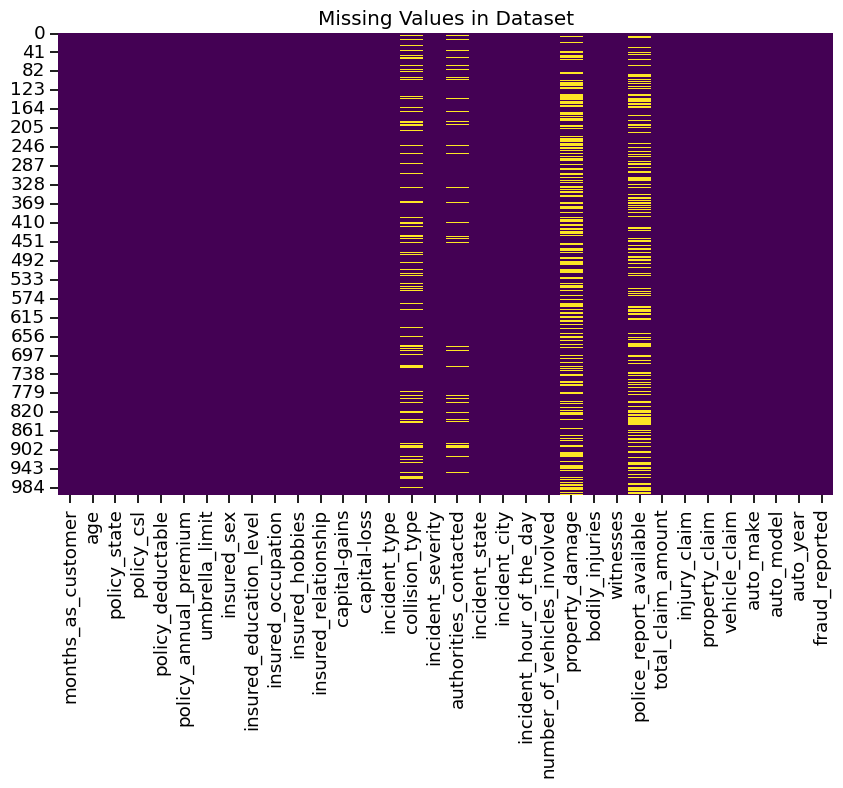

In [277]:
# Visualize missing values using a heatmap

plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cbar=False, cmap="viridis")
plt.title('Missing Values in Dataset')
plt.show()

In [278]:
# Impute missing numerical values with mean and categorical with mode

numerical_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')

data[numerical_cols] = numerical_imputer.fit_transform(data[numerical_cols])
data[categorical_cols] = categorical_imputer.fit_transform(data[categorical_cols].astype(str))

# Print missing values count after imputation

print("Missing values after imputation:\n", data.isnull().sum().sum())

Missing values after imputation:
 0


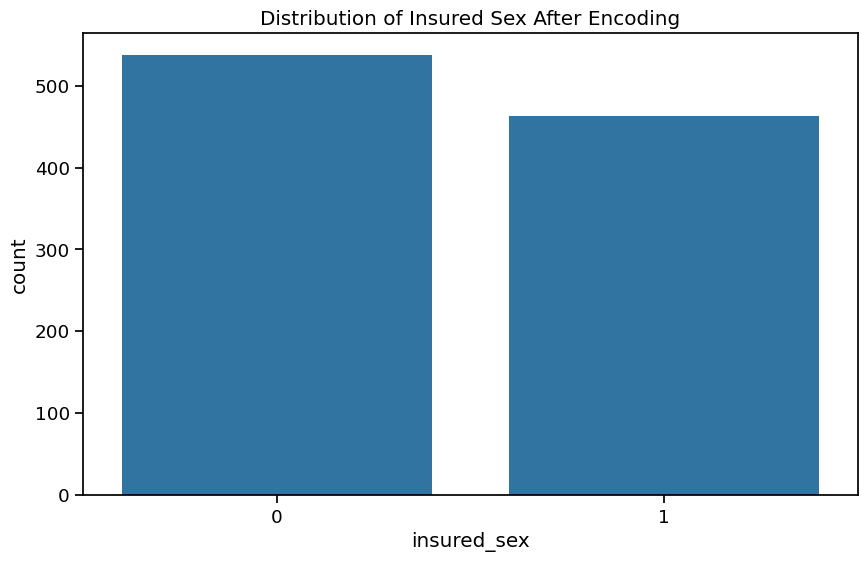

In [279]:
# Encode categorical features using LabelEncoder

label_encoder = LabelEncoder()
for col in categorical_cols:
    data[col] = label_encoder.fit_transform(data[col])

# Visualize the distribution of one of the encoded categorical features

plt.figure(figsize=(10, 6))
sns.countplot(x=data['insured_sex'])
plt.title('Distribution of Insured Sex After Encoding')
plt.show()

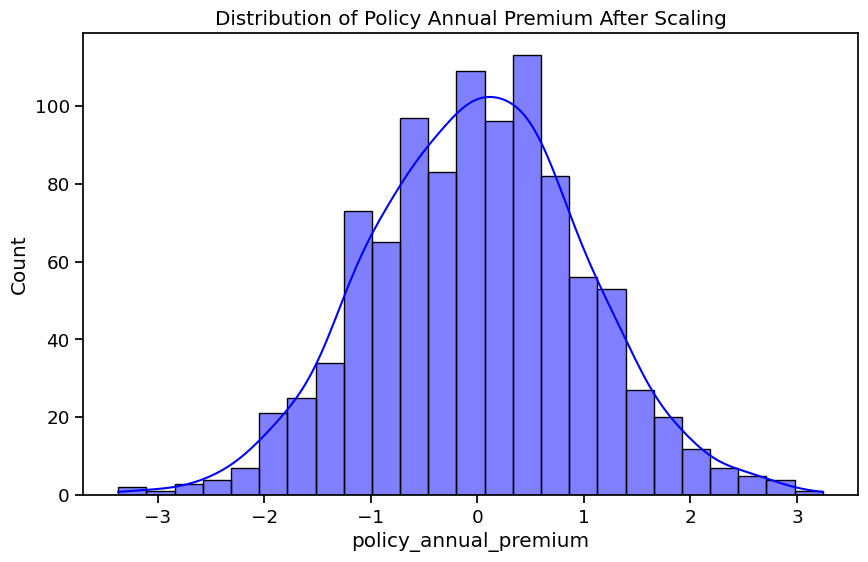

In [280]:
# Scale numerical features

scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Visualize the distribution of one of the scaled numerical features

plt.figure(figsize=(10, 6))
sns.histplot(data['policy_annual_premium'], kde=True, color="blue")
plt.title('Distribution of Policy Annual Premium After Scaling')
plt.show()

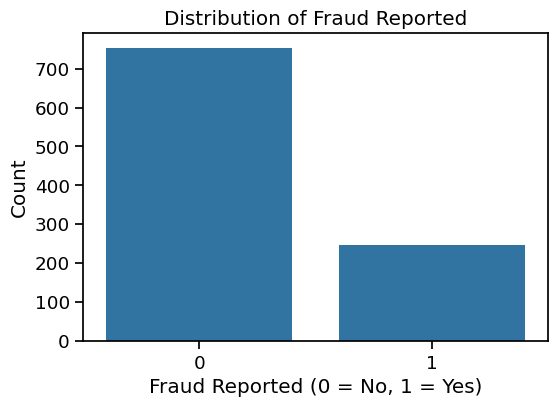

In [281]:
# Convert target column 'fraud_reported' to binary (1 for Y, 0 for N)

data['fraud_reported'] = data['fraud_reported'].apply(lambda x: 1 if x == 'Y' else 0)

# Visualize the distribution of the target variable

plt.figure(figsize=(6, 4))
sns.countplot(x='fraud_reported', data=data)
plt.title("Distribution of Fraud Reported")
plt.xlabel("Fraud Reported (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

In [282]:
# Split the dataset into features (X) and target (y)

X = data.drop(columns=['fraud_reported'])
y = data['fraud_reported']

In [283]:
# Split into training and testing sets (80% training, 20% testing)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shape of the training and testing sets
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")


Training set shape: (800, 33)
Testing set shape: (200, 33)


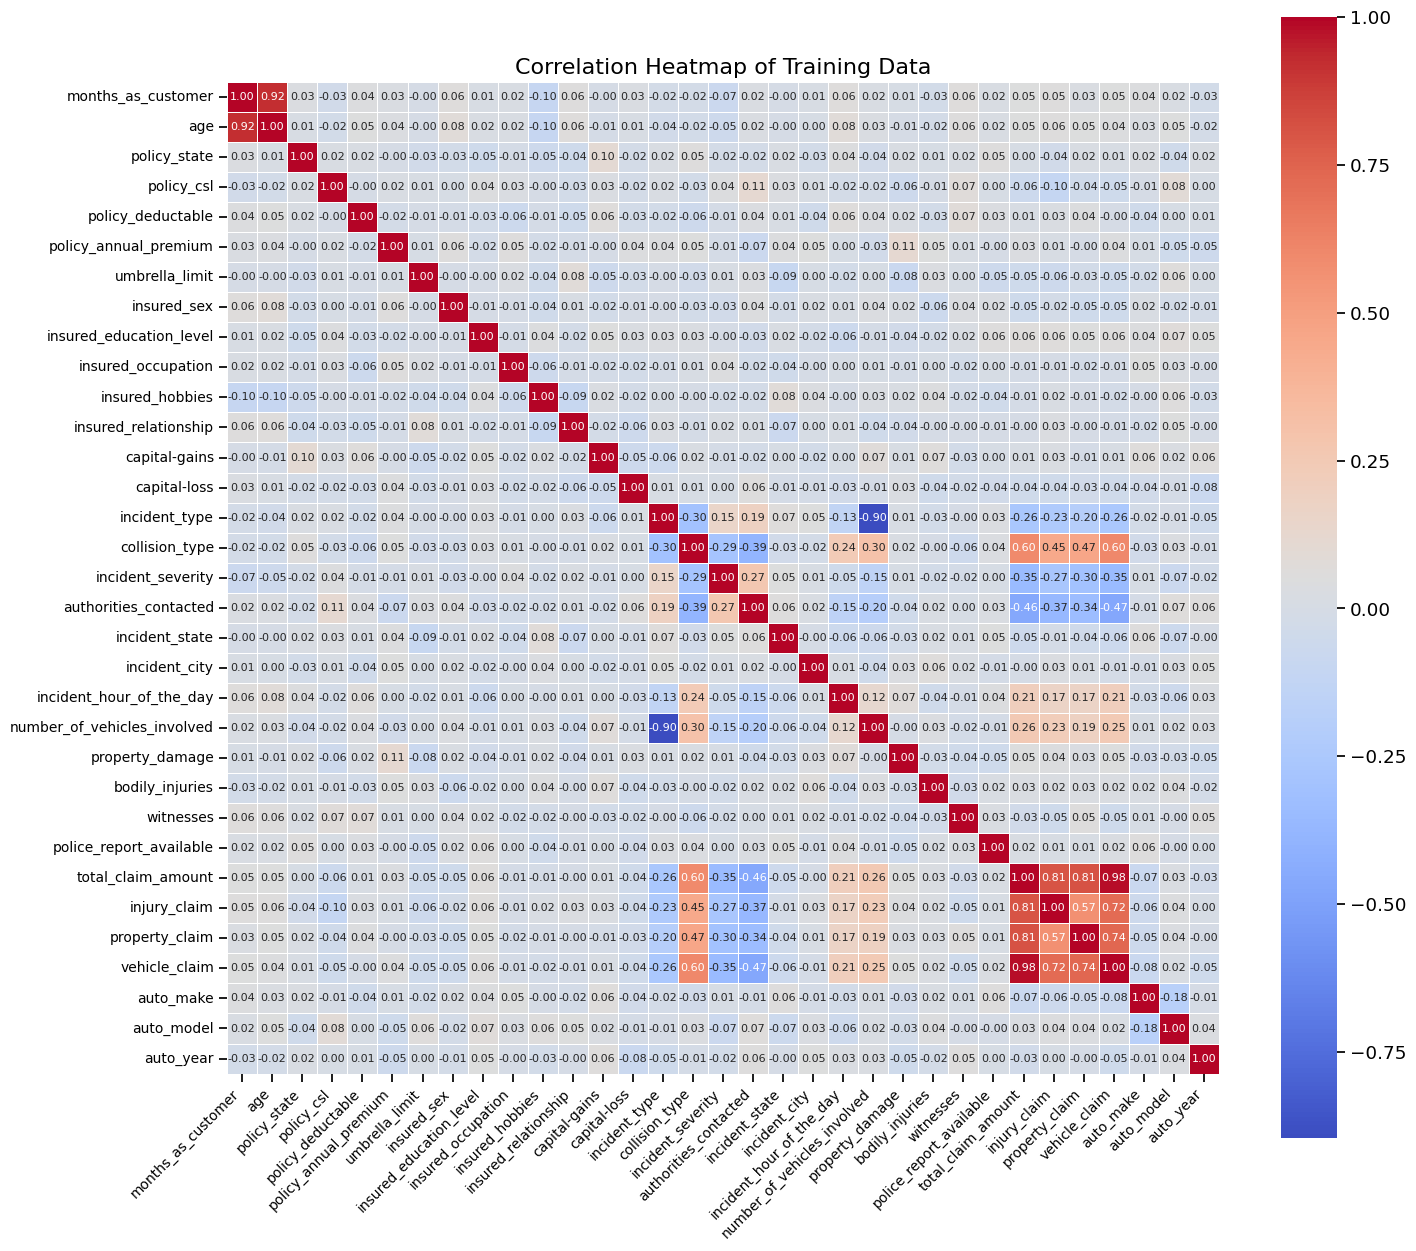

In [284]:
# Visualize the correlation heatmap of the processed training data

plt.figure(figsize=(15, 15))
correlation_matrix = X_train.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            linewidths=0.5, square=True, cbar_kws={"shrink": 0.8},
            annot_kws={"size": 8})

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.title("Correlation Heatmap of Training Data", fontsize=16)
plt.tight_layout()

# Display the plot
plt.show()


In [285]:
# Display the processed training data sample

print("Processed Training Data Sample:")
print(X_train.head())

Processed Training Data Sample:
     months_as_customer       age  policy_state  policy_csl  \
29             0.321983  0.662455             0           2   
535           -1.207712 -1.745676             2           1   
695            0.739173  0.662455             2           1   
557           -1.225095 -1.417295             0           2   
836            0.461047  0.443534             1           0   

     policy_deductable  policy_annual_premium  umbrella_limit  insured_sex  \
29            1.412784              -0.622451       -0.479476            0   
535          -0.222383              -0.641095       -0.479476            0   
695           1.412784              -0.143400       -0.479476            0   
557          -1.039966               0.998314        2.133471            1   
836          -0.222383              -1.153746       -0.479476            0   

     insured_education_level  insured_occupation  ...  bodily_injuries  \
29                         6                  

# **Model Architecture**

In [311]:
# Model Architecture
def build_optimized_mlp(input_dim):
    model = Sequential()

    # First hidden layer with L2 regularization, Batch Normalization, and Dropout
    model.add(Dense(128, activation='relu', input_dim=input_dim, kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))  # 30% dropout rate

    # Second hidden layer with L2 regularization, Batch Normalization, and Dropout
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))  # For binary classification

    return model

# Build the model
input_dim = X_train.shape[1]
model = build_optimized_mlp(input_dim)

# Print model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_88 (Dense)                     │ (None, 128)                 │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_89 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_90 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,441 (52.50 KB)

 Trainable params: 13,057 (51.00 KB)

 Non-trainable params: 384 (1.50 KB)

# **Training**

In [312]:
# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Early Stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2,
                    callbacks=[early_stopping])

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.5426 - loss: 1.1082 - val_accuracy: 0.2688 - val_loss: 2.3619
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5383 - loss: 0.9937 - val_accuracy: 0.2875 - val_loss: 1.4936
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5354 - loss: 1.0368 - val_accuracy: 0.3063 - val_loss: 1.1958
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5230 - loss: 1.0042 - val_accuracy: 0.3250 - val_loss: 1.0241
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5244 - loss: 0.9896 - val_accuracy: 0.3438 - val_loss: 0.9142
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5071 - loss: 1.0757 - val_accuracy: 0.4062 - val_loss: 1.0794
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4962 - loss: 0.9998 - val_accuracy: 0.4812 - val_loss: 0.8742
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5329 - loss: 1.0473 - val_accuracy: 0.5250 - val_loss

# **Evaluation**

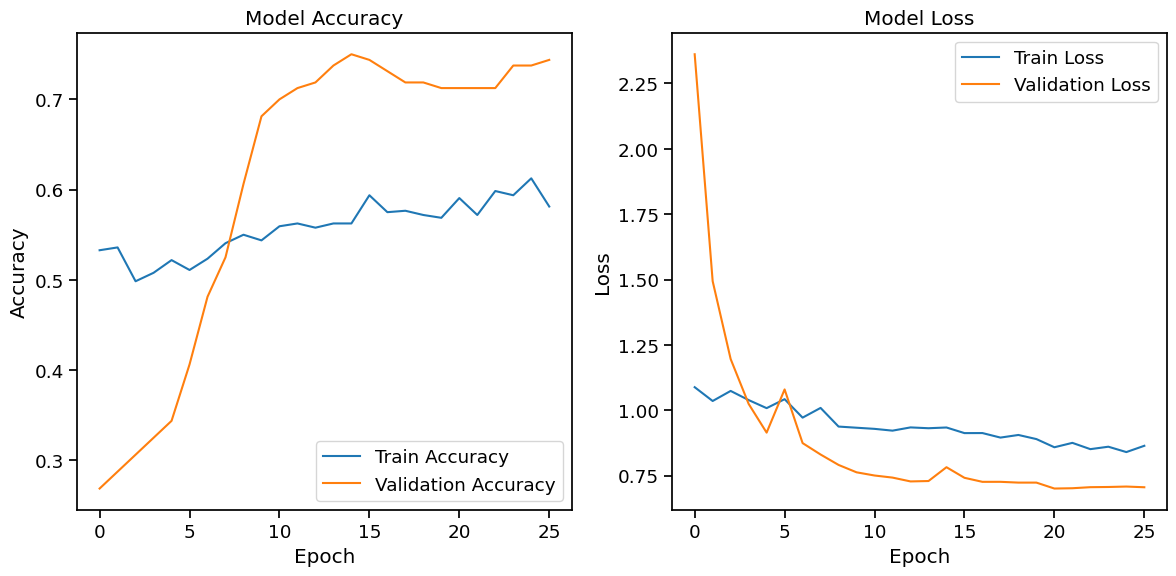

In [316]:
# Plot training & validation accuracy values
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    # Display plots
    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

In [317]:
# Evaluate the model on the test set

def evaluate_model(model, X_test, y_test):
    print("Evaluating the model on test data...")
    # Predict on the test data
    y_pred = (model.predict(X_test) > 0.5).astype(int)

    # Print evaluation metrics
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred) * 100  # Convert to percentage
    print(f"\nAccuracy on test data: {accuracy:.2f}%")

    return accuracy

# Evaluate the model
evaluate_model(model, X_test, y_test)



Evaluating the model on test data...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.97      0.82       145
           1       0.00      0.00      0.00        55

    accuracy                           0.70       200
   macro avg       0.36      0.48      0.41       200
weighted avg       0.52      0.70      0.60       200


Accuracy on test data: 70.00%


70.0